# Lightkurve periodogram & power-spectrum notebook (Coarse → Refined BLS)

This notebook is a revised version that implements a two-step Box‑Least‑Squares (BLS) search:
1) a fast coarse grid to find candidate peaks, then
2) a refined, high-resolution search around the strongest candidates.

It uses your CSV `tic437011608flattened-2min.csv` by default and the `Flattened Flux` column.

Generated: 2025-09-11 17:29 UTC

---



In [ ]:
# Install required packages (uncomment & run if required)
# !pip install lightkurve astropy numpy pandas matplotlib scipy
# After installing, restart the kernel if asked.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.timeseries import LombScargle, BoxLeastSquares
try:
    import lightkurve as lk
except Exception as e:
    print('lightkurve not available; some convenience plotting may be skipped.', e)

%matplotlib inline
plt.rcParams['figure.figsize'] = (10,4)


In [2]:
# === EDIT THIS PATH IF YOUR FILE IS LOCATED ELSEWHERE ===
DATA_PATH = "../data/tic437011608flattened-20s.csv"

df = pd.read_csv(DATA_PATH)
print('Columns found:', df.columns.tolist())
display(df.head())

# Detect columns
time_col_candidates = [c for c in df.columns if 'time' in c.lower() or 'bjd' in c.lower()]
if any('flatten' in c.lower() for c in df.columns):
    flux_col_candidates = [c for c in df.columns if 'flatten' in c.lower()]
else:
    flux_col_candidates = [c for c in df.columns if 'flux' in c.lower()]

time_col = time_col_candidates[0] if time_col_candidates else df.columns[0]
flux_col = flux_col_candidates[0] if flux_col_candidates else df.columns[1]

time_rel = df[time_col].values.astype(float)
time_bjd = time_rel + 2457000.0
flux = df[flux_col].values.astype(float)

print(f"Using time column: '{time_col}' (interpreted as BJD-2457000).")
print(f"Using flux column: '{flux_col}'. Number of points: {len(time_rel)}") 


Columns found: ['Time (BJD-2457000)', ' Flux', ' Flattened Flux']


,Time (BJD-2457000),Flux,Flattened Flux
0,3235.348866,1.001028,0.999057
1,3235.349329,1.001114,0.999141
2,3235.349560,1.001423,0.999449
3,3235.349792,1.001788,0.999813
4,3235.350023,1.002057,1.000080


Using time column: 'Time (BJD-2457000)' (interpreted as BJD-2457000).
Using flux column: ' Flattened Flux'. Number of points: 191904


In [3]:
# Create a LightKurve LightCurve object (optional)
try:
    lc = lk.LightCurve(time=time_rel, flux=flux)
    print('LightKurve object created.')
except Exception as e:
    print('Lightkurve not available or failed to create LightCurve object:', e)
    lc = None


LightKurve object created.


Data points: 191904
Coarse periods: 1000 Refined resolution: 5000
Running coarse autopower... (this is reasonably fast)


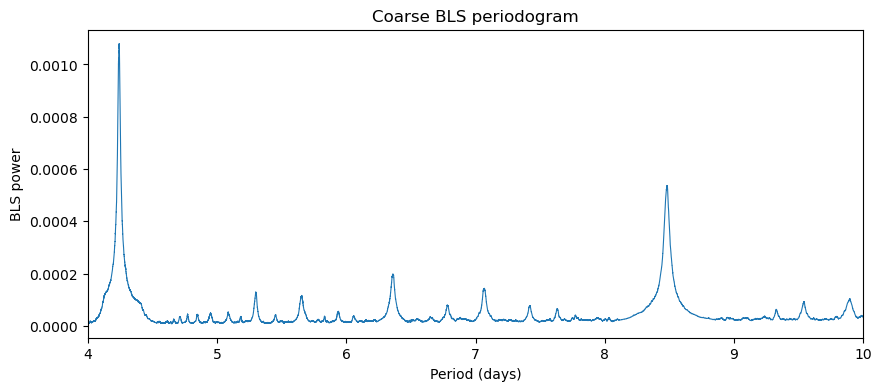

Candidate periods from coarse search (days): [4.240907527579696, 4.241335105855881, 4.241192570184263]


In [4]:
# ===== Two-step BLS: coarse -> refined =====
# PARAMETERS (tweakable)
min_period = 4.0      # days
max_period = 10.0     # days

# Coarse grid (fast)
n_coarse = 1000       # fewer trial periods to run quickly
durations = np.linspace(0.005, 2.0, 30)   # grid of durations (days) for autopower scan

# Refined grid (local around top peaks)
n_refined = 5000      # resolution for refined search (only around candidate peaks)
refine_width = 0.02   # fractional window around coarse peak to refine (e.g. 0.02 = +-2%)

print('Data points:', len(time_rel))
print('Coarse periods:', n_coarse, 'Refined resolution:', n_refined)

# --- Coarse BLS using astropy BoxLeastSquares.autopower ---
periods_coarse = np.linspace(min_period, max_period, n_coarse)
bls = BoxLeastSquares(time_rel, flux)
print('Running coarse autopower... (this is reasonably fast)')
try:
    # autopower accepts durations and returns arrays of period, power, duration...
    coarse_result = bls.autopower(durations, minimum_period=min_period, maximum_period=max_period)
    # Depending on astropy version, coarse_result may be a table-like with .period and .power
    period_c = coarse_result.period
    power_c = coarse_result.power
    plt.figure(); plt.plot(period_c, power_c, lw=0.8)
    plt.xlabel('Period (days)'); plt.ylabel('BLS power')
    plt.title('Coarse BLS periodogram'); plt.xlim(min_period, max_period)
    plt.show()
    # pick top candidate periods (local maxima)
    from scipy.signal import find_peaks
    peaks, _ = find_peaks(power_c, height=np.nanmedian(power_c) + 3*np.nanstd(power_c))
    if len(peaks) == 0:
        # fallback: choose the global maximum
        best_idx_coarse = np.nanargmax(power_c)
        candidate_periods = [period_c[best_idx_coarse]]
    else:
        # sort peaks by power and take top 3 candidates
        peak_powers = power_c[peaks]
        order = np.argsort(peak_powers)[::-1]
        candidate_periods = list(period_c[peaks][order][:3])
    print('Candidate periods from coarse search (days):', candidate_periods)
except Exception as e:
    print('Coarse BLS autopower failed:', e)
    period_c = periods_coarse
    power_c = np.zeros_like(period_c)
    candidate_periods = []

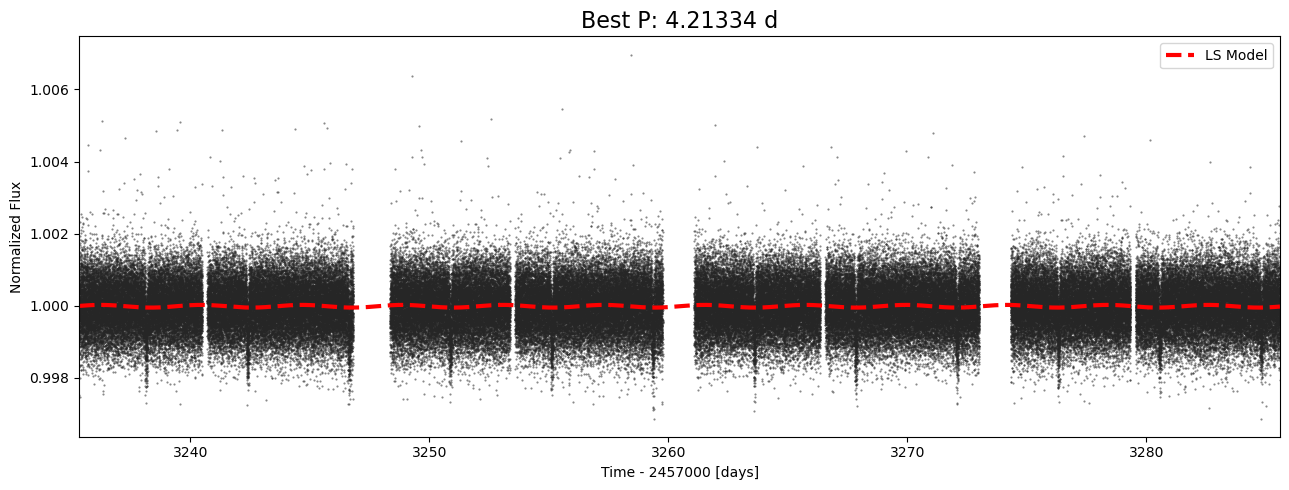

In [9]:
# Plot a sinusoidal Lomb-Scargle model at the chosen best period
import numpy as np
import matplotlib.pyplot as plt
from astropy.timeseries import LombScargle

# --- choose best period from available results (priority: astropy BLS -> lightkurve BLS -> LS) ---
best_period = None
if 'best_period_astropy' in globals() and best_period_astropy is not None:
    best_period = float(best_period_astropy)
elif 'best_period_lk' in globals() and best_period_lk is not None:
    try:
        best_period = float(best_period_lk.value)
    except Exception:
        best_period = float(best_period_lk)
elif 'best_period_ls' in globals():
    best_period = float(best_period_ls)

if best_period is None:
    raise RuntimeError("No best period found. Run the periodogram cells first (BLS or LS).")

# frequency for Lomb-Scargle
best_freq = 1.0 / best_period

# make a dense time grid spanning your observations (use same time units as your time axis)
tmin, tmax = time_rel.min(), time_rel.max()
tgrid = np.linspace(tmin, tmax, 10000)   # dense grid for a smooth curve

# fit sinusoid model at that single frequency using LombScargle
ls = LombScargle(time_rel, flux)
model = ls.model(tgrid, best_freq)   # returns best-fit sinusoid+offset at that frequency

# optionally get a "max power" value to annotate the plot (try various sources)
max_power = None
if 'best_power_astropy' in globals() and best_power_astropy is not None:
    max_power = best_power_astropy
elif 'bls_result' in globals() and hasattr(bls_result, 'power'):
    # if using astropy BoxLeastSquares.autopower
    try:
        max_power = float(np.nanmax(bls_result.power))
    except Exception:
        max_power = None

# --- plotting ---
plt.figure(figsize=(13,5))
plt.plot(time_rel, flux, '.', color='0.15', markersize=1, alpha=0.6)   # raw points (time is BJD-2457000)
plt.plot(tgrid, model, linestyle='--', linewidth=3, color='red', label='LS Model')  # sinusoidal model

plt.xlabel('Time - 2457000 [days]')
plt.ylabel('Normalized Flux')
title = f'Best P: {best_period:.5f} d'
if max_power is not None:
    title += f'    Max Power: {max_power:.2f}'
plt.title(title, fontsize=16)
plt.legend(frameon=True)
plt.xlim(tmin, tmax)
plt.tight_layout()
plt.show()


In [ ]:
# # --- Refined searches around each candidate ---
# refined_results = []
# for p0 in candidate_periods:
#     pmin = p0*(1.0 - refine_width)
#     pmax = p0*(1.0 + refine_width)
#     print(f'Refining around {p0:.6f} d -> window [{pmin:.6f}, {pmax:.6f}]')
#     periods_ref = np.linspace(pmin, pmax, n_refined)
#     try:
#         # autopower with a single period range: use a narrower durations grid around the coarse best duration
#         refined_autopower = bls.autopower(durations, minimum_period=pmin, maximum_period=pmax, goal='snr')
#         # refined_autopower may have .period and .power
#         per_r = refined_autopower.period
#         pow_r = refined_autopower.power
#         # find best
#         best_idx = np.nanargmax(pow_r)
#         best_p = per_r[best_idx]
#         best_pow = pow_r[best_idx]
#         best_dur = refined_autopower.duration[best_idx] if hasattr(refined_autopower, 'duration') else np.nan
#         refined_results.append({'start':pmin, 'stop':pmax, 'best_period':float(best_p),
#                                 'best_power':float(best_pow), 'best_duration':float(best_dur)})
#         plt.figure(); plt.plot(per_r, pow_r, lw=0.8)
#         plt.xlabel('Period (days)'); plt.ylabel('BLS power')
#         plt.title(f'Refined BLS around {p0:.6f} d (best {best_p:.6f} d)')
#         plt.show()
#     except Exception as e:
#         print('Refined autopower failed for window', pmin, pmax, e)

# print('\nRefined results (summary):')
# for r in refined_results:
#     print(r)
    
# # If lightkurve is available, also attempt a lightkurve BLS as a convenience check
# if lc is not None:
#     try:
#         print('\nAttempting Lightkurve BLS convenience call (may differ slightly):')
#         lk_pg = lc.to_periodogram(method='bls', minimum_period=min_period, maximum_period=max_period)
#         display(lk_pg)  # if this supports display in your environment
#         print('Lightkurve BLS best period:', lk_pg.period_at_max_power)
#     except Exception as e:
#         print('Lightkurve BLS convenience call failed:', e)


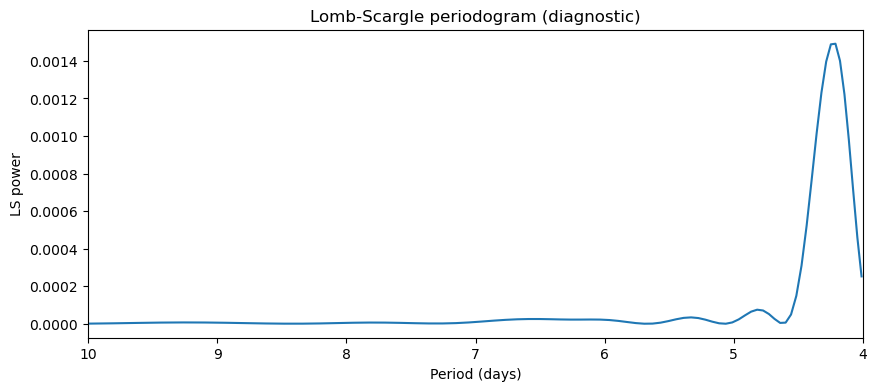

Lomb-Scargle best period (max power): 4.21334490004372


In [10]:
# Lomb-Scargle for diagnostics
min_freq = 1.0 / max_period
max_freq = 1.0 / min_period
ls = LombScargle(time_rel, flux)
freq, power = ls.autopower(minimum_frequency=min_freq, maximum_frequency=max_freq, samples_per_peak=10)
periods_ls = 1.0 / freq
plt.figure(); plt.plot(periods_ls, power); plt.xlabel('Period (days)'); plt.ylabel('LS power'); plt.xlim(max_period, min_period)
plt.title('Lomb-Scargle periodogram (diagnostic)'); plt.show()
best_idx_ls = np.nanargmax(power)
best_period_ls = periods_ls[best_idx_ls]
print('Lomb-Scargle best period (max power):', best_period_ls)


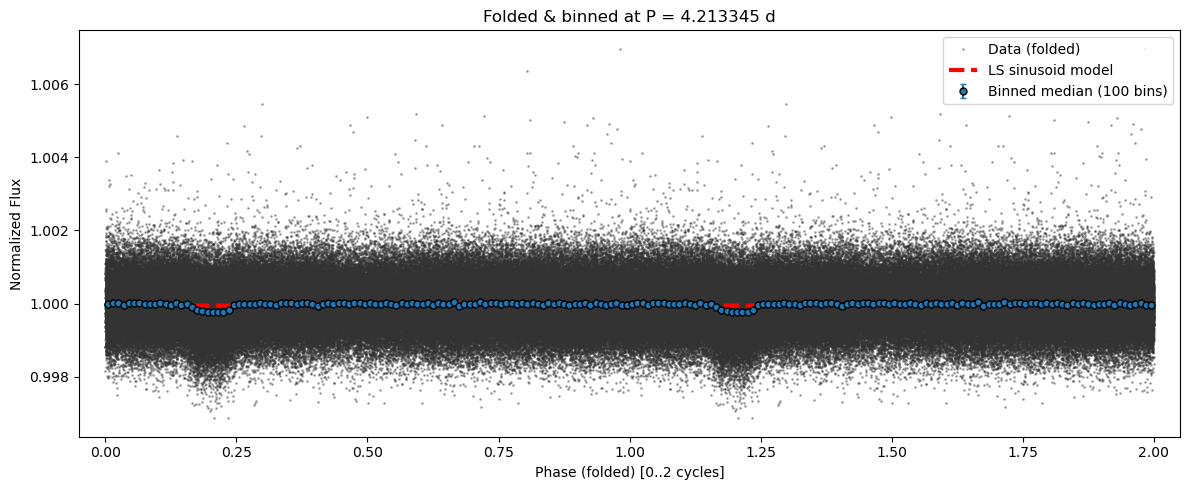

In [14]:
# Folded + binned plot with Lomb-Scargle sinusoid overlay (two cycles)
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from astropy.timeseries import LombScargle

# --- pick best period (priority: astropy BLS -> lightkurve BLS -> LS) ---
best_period = None
if 'best_period_astropy' in globals() and best_period_astropy is not None:
    best_period = float(best_period_astropy)
elif 'best_period_lk' in globals() and best_period_lk is not None:
    try:
        best_period = float(best_period_lk.value)
    except Exception:
        best_period = float(best_period_lk)
elif 'best_period_ls' in globals():
    best_period = float(best_period_ls)

if best_period is None:
    raise RuntimeError("No best period found. Run the periodogram cells first (BLS or LS).")

# --- choose epoch reference so model and folding align with data ---
t0 = time_rel.min()   # epoch reference (you can change to a fitted epoch if available)
P = best_period

# --- compute phase for data (0..1) and center transit at 0.5 for convenience ---
phase = ((time_rel - t0) % P) / P
phase = (phase + 0.5) % 1.0

# --- prepare binned folded curve ---
nbins = 100
bin_stat = stats.binned_statistic(phase, flux, statistic='median', bins=nbins)
bin_means = bin_stat.statistic
bin_edges = bin_stat.bin_edges
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

# also compute bin standard deviation / count for errorbars
bin_std = stats.binned_statistic(phase, flux, statistic='std', bins=nbins).statistic
bin_count = stats.binned_statistic(phase, flux, statistic='count', bins=nbins).statistic
bin_err = np.where(bin_count>0, bin_std / np.sqrt(bin_count), np.nan)

# --- Lomb-Scargle model evaluated on a dense time grid and folded ---
ls = LombScargle(time_rel, flux)
freq = 1.0 / P
# evaluate model on a dense grid spanning one period, anchored to t0
t_model = t0 + np.linspace(0, P, 2000)
model_vals = ls.model(t_model, freq)
phase_model = ((t_model - t0) % P) / P
# center same as data (shift by +0.5)
phase_model = (phase_model + 0.5) % 1.0

# For plotting two cycles, duplicate phase/model and bin centers
phase_dup = np.concatenate([phase, phase + 1.0])
flux_dup  = np.concatenate([flux,  flux])
# Sort duplicated arrays for nicer scatter plotting (optional)
order = np.argsort(phase_dup)
phase_dup = phase_dup[order]
flux_dup  = flux_dup[order]

bin_centers_dup = np.concatenate([bin_centers, bin_centers + 1.0])
bin_means_dup   = np.concatenate([bin_means, bin_means])
bin_err_dup     = np.concatenate([bin_err, bin_err])

phase_model_sorted_idx = np.argsort(phase_model)
phase_model_plot = np.concatenate([phase_model[phase_model_sorted_idx],
                                  phase_model[phase_model_sorted_idx] + 1.0])
model_plot = np.concatenate([model_vals[phase_model_sorted_idx],
                             model_vals[phase_model_sorted_idx]])

# --- Plot ---
plt.figure(figsize=(12,5))

# faint raw folded points (two cycles)
plt.plot(phase_dup, flux_dup, '.', ms=2, color='0.2', alpha=0.35, label='Data (folded)')

# binned medians with errorbars
plt.errorbar(bin_centers_dup, bin_means_dup, yerr=bin_err_dup, fmt='o', ms=5,
             mec='k', mfc='C0', ecolor='C0', capsize=2, label=f'Binned median ({nbins} bins)')

# LS sinusoidal model (two cycles)
plt.plot(phase_model_plot, model_plot, '--', lw=3, color='red', label='LS sinusoid model')

plt.xlim(-0.05, 2.05)
plt.xlabel('Phase (folded) [0..2 cycles]')
plt.ylabel('Normalized Flux')
plt.title(f'Folded & binned at P = {P:.6f} d')
plt.legend(frameon=True, loc='upper right')
plt.tight_layout()
plt.show()


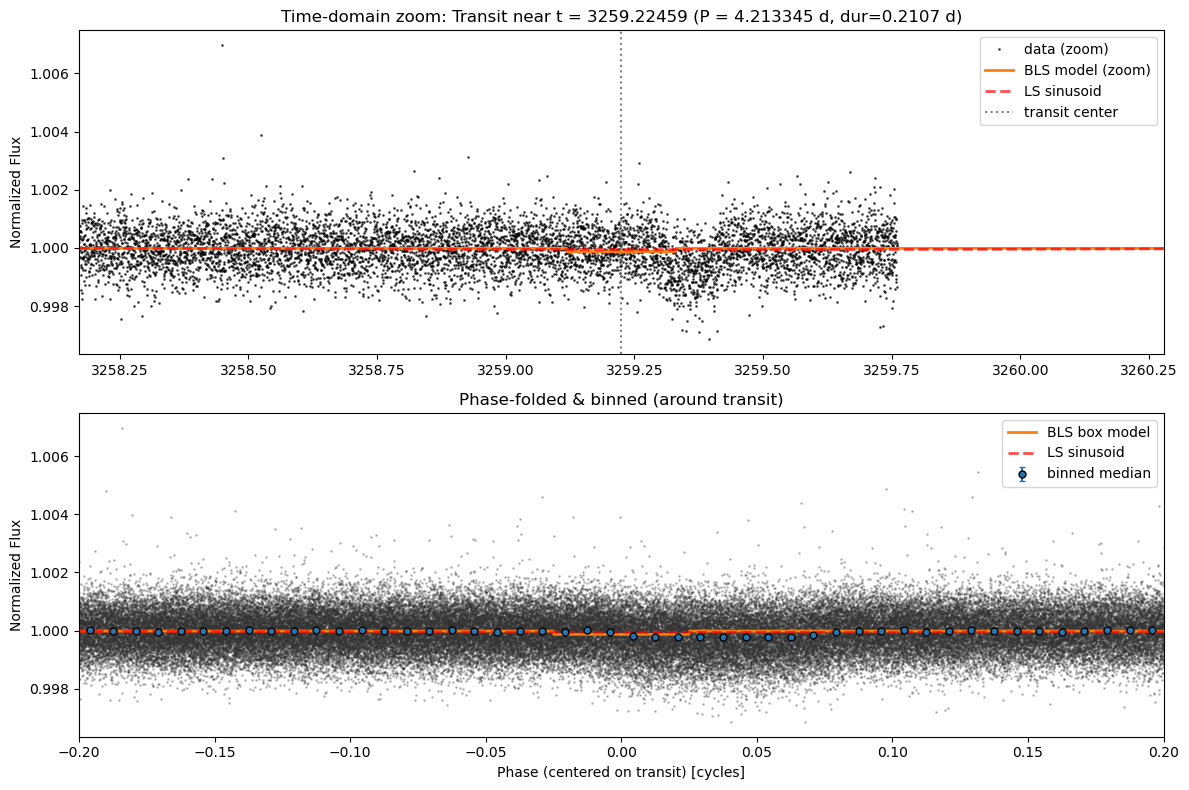

In [15]:
# Zoom + phase-folded binned transit plot with BLS model overlay
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from astropy.timeseries import BoxLeastSquares, LombScargle

# -------------------------
# 1) Gather period & duration & transit time (robustly)
# -------------------------
# best period priority: refined_results -> astropy BLS -> lightkurve -> LS
P = None
if 'refined_results' in globals() and len(refined_results) > 0 and 'best_period' in refined_results[0]:
    P = float(refined_results[0]['best_period'])
elif 'best_period_astropy' in globals() and best_period_astropy is not None:
    P = float(best_period_astropy)
elif 'best_period_lk' in globals() and best_period_lk is not None:
    try:
        P = float(best_period_lk.value)
    except Exception:
        P = float(best_period_lk)
elif 'best_period_ls' in globals():
    P = float(best_period_ls)

if P is None:
    raise RuntimeError("No best period found (run the periodogram cells first).")

# duration: try to read from refined_results or bls_result, otherwise default to 5% of period
dur = None
if 'refined_results' in globals() and len(refined_results) > 0 and 'best_duration' in refined_results[0]:
    dur = float(refined_results[0]['best_duration'])
elif 'bls_result' in globals() and hasattr(bls_result, 'duration'):
    try:
        # find index of max power if possible
        idx = np.nanargmax(bls_result.power)
        dur = float(bls_result.duration[idx])
    except Exception:
        dur = None

if dur is None or not np.isfinite(dur):
    dur = max(0.05 * P, 0.01)  # default: 5% of period, min 0.01 days

# transit time t0: try to obtain from available BLS outputs, else estimate from folded minimum
t0 = None
# check for astropy autopower outputs that may carry a transit_time array
for candidate in ('refined_autopower','coarse_result','bls_result'):
    if candidate in globals():
        obj = globals()[candidate]
        if hasattr(obj, 'transit_time'):
            try:
                # use transit_time corresponding to max power entry
                idx = np.nanargmax(obj.power)
                t0 = float(obj.transit_time[idx])
                break
            except Exception:
                pass

# Lightkurve doesn't always provide transit_time attribute; if none found, estimate:
if t0 is None:
    # fold with a reference epoch = earliest time
    tref = time_rel.min()
    phase_all = ((time_rel - tref) % P) / P
    # bin phase to find lowest-median bin -> approximate transit phase
    nbins_est = 200
    bin_med = stats.binned_statistic(phase_all, flux, statistic='median', bins=nbins_est).statistic
    bin_edges = stats.binned_statistic(phase_all, flux, statistic='median', bins=nbins_est).bin_edges
    min_idx = np.nanargmin(bin_med)
    phase_min = 0.5 * (bin_edges[min_idx] + bin_edges[min_idx+1])
    # convert that phase to a time (t0)
    t0 = tref + phase_min * P

# -------------------------
# 2) pick a single transit (closest to the middle of the time series)
# -------------------------
t_med = np.median(time_rel)
k = np.round((t_med - t0) / P).astype(int)
t_center = t0 + k * P   # center time of the chosen transit

# window for zooming: pick a few durations (and at least a small floor)
window_days = max(5 * dur, 0.05)   # 5 x transit duration or at least 0.05 d
tmin_zoom = t_center - window_days
tmax_zoom = t_center + window_days

in_window = (time_rel >= tmin_zoom) & (time_rel <= tmax_zoom)

# -------------------------
# 3) prepare BLS box model (if BoxLeastSquares available) and LS sinusoid (optional)
# -------------------------
bls_model_time = None
bls_model_flux = None
try:
    bls_inst = BoxLeastSquares(time_rel, flux)
    # astropy BoxLeastSquares.model(time, period, duration, transit_time)
    tgrid = np.linspace(tmin_zoom, tmax_zoom, 2000)
    bls_model_flux = bls_inst.model(tgrid, P, dur, t_center)
    bls_model_time = tgrid
except Exception as e:
    # fallback: simple box model using depth estimated from binned min
    # estimate depth as median(level outside transit) - median(in transit)
    # define "in transit" via phase distance from t_center
    phase = ( (time_rel - t_center) / P )
    phase_dist = np.abs((phase + 0.5) % 1.0 - 0.5)
    in_transit_mask = phase_dist < (dur / P)  # approx
    if np.any(~in_transit_mask):
        out_level = np.nanmedian(flux[~in_transit_mask])
    else:
        out_level = np.nanmedian(flux)
    in_level = np.nanmedian(flux[in_transit_mask]) if np.any(in_transit_mask) else out_level
    depth = out_level - in_level
    # make a simple box (1 outside transit, 1-depth inside)
    tgrid = np.linspace(tmin_zoom, tmax_zoom, 2000)
    phase_grid = ((tgrid - t_center) / P)
    phase_dist_grid = np.abs((phase_grid + 0.5) % 1.0 - 0.5)
    box = np.where(phase_dist_grid < (dur / P), out_level - depth, out_level)
    bls_model_time = tgrid
    bls_model_flux = box

# optional LS sinusoid model (for visualization)
ls_model_time = np.linspace(tmin_zoom, tmax_zoom, 2000)
try:
    ls = LombScargle(time_rel, flux)
    ls_model = ls.model(ls_model_time, 1.0 / P)
except Exception:
    ls_model = None

# -------------------------
# 4) phase-folded & binned around the chosen transit
# -------------------------
# Fold all data about the chosen transit center; center transit at phase=0
phase_all = ((time_rel - t_center) / P)
phase_all = (phase_all + 0.5) % 1.0 - 0.5   # in [-0.5, 0.5]

# choose a phase window to plot (we'll show a few transit durations on each side)
phase_window = max(5 * (dur / P), 0.02)  # at least 0.02 cycles
phase_mask = np.abs(phase_all) <= phase_window

# compute binned median + stderr across the folded domain within the phase mask
phase_vals = phase_all[phase_mask]
flux_vals = flux[phase_mask]

nbins_fold = 60
bin_stat = stats.binned_statistic(phase_vals, flux_vals, statistic='median', bins=nbins_fold)
bin_centers = 0.5 * (bin_stat.bin_edges[:-1] + bin_stat.bin_edges[1:])
bin_meds = bin_stat.statistic
bin_std = stats.binned_statistic(phase_vals, flux_vals, statistic='std', bins=nbins_fold).statistic
bin_count = stats.binned_statistic(phase_vals, flux_vals, statistic='count', bins=nbins_fold).statistic
bin_err = np.where(bin_count > 0, bin_std / np.sqrt(bin_count), np.nan)

# prepare model folded onto phase for overlay
# fold bls_model_time and ls_model_time to phase
bls_phase = ((bls_model_time - t_center) / P)
bls_phase = (bls_phase + 0.5) % 1.0 - 0.5
ls_phase = None
if ls_model is not None:
    ls_phase = ((ls_model_time - t_center) / P)
    ls_phase = (ls_phase + 0.5) % 1.0 - 0.5

# sort for plotting
sort_idx_bls = np.argsort(bls_phase)
bls_phase_plot = np.concatenate([bls_phase[sort_idx_bls] - 1.0, bls_phase[sort_idx_bls], bls_phase[sort_idx_bls] + 1.0])
bls_flux_plot  = np.concatenate([bls_model_flux[sort_idx_bls], bls_model_flux[sort_idx_bls], bls_model_flux[sort_idx_bls]])

if ls_model is not None:
    sort_idx_ls = np.argsort(ls_phase)
    ls_phase_plot = np.concatenate([ls_phase[sort_idx_ls] - 1.0, ls_phase[sort_idx_ls], ls_phase[sort_idx_ls] + 1.0])
    ls_flux_plot  = np.concatenate([ls_model[sort_idx_ls], ls_model[sort_idx_ls], ls_model[sort_idx_ls]])

# duplicate binned points for two cycles (nice visual)
bin_centers_dup = np.concatenate([bin_centers - 1.0, bin_centers, bin_centers + 1.0])
bin_meds_dup = np.concatenate([bin_meds, bin_meds, bin_meds])
bin_err_dup = np.concatenate([bin_err, bin_err, bin_err])

# -------------------------
# 5) Plot: top = zoomed time-domain, bottom = folded binned with model
# -------------------------
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), gridspec_kw={'height_ratios':[1,1]})

# Top: time-domain zoom around chosen transit
ax1.plot(time_rel[in_window], flux[in_window], '.', markersize=2, alpha=0.6, color='k', label='data (zoom)')
ax1.plot(bls_model_time, bls_model_flux, '-', color='C1', lw=2, label='BLS model (zoom)')
if ls_model is not None:
    ax1.plot(ls_model_time, ls_model, '--', color='red', lw=2, alpha=0.7, label='LS sinusoid')
ax1.axvline(t_center, color='0.5', ls=':', label='transit center')
ax1.set_xlim(tmin_zoom, tmax_zoom)
ax1.set_ylabel('Normalized Flux')
ax1.set_title(f'Time-domain zoom: Transit near t = {t_center:.5f} (P = {P:.6f} d, dur={dur:.4f} d)')
ax1.legend(loc='upper right', frameon=True)

# Bottom: folded & binned with model overlay (show two cycles)
ax2.plot(phase_vals, flux_vals, '.', color='0.2', ms=2, alpha=0.25)
ax2.errorbar(bin_centers_dup, bin_meds_dup, yerr=bin_err_dup, fmt='o', ms=5, mec='k', mfc='C0', ecolor='C0', capsize=2, label='binned median')

# overlay BLS model (two cycles)
ax2.plot(bls_phase_plot, bls_flux_plot, '-', color='C1', lw=2, label='BLS box model')
if ls_model is not None:
    ax2.plot(ls_phase_plot, ls_flux_plot, '--', color='red', lw=2, alpha=0.7, label='LS sinusoid')

ax2.set_xlim(-0.2, 0.2)   # zoom in on transit region (±0.2 cycles); adjust as needed
ax2.set_xlabel('Phase (centered on transit) [cycles]')
ax2.set_ylabel('Normalized Flux')
ax2.set_title('Phase-folded & binned (around transit)')
ax2.legend(loc='upper right', frameon=True)
plt.tight_layout()
plt.show()


In [16]:
# Overlay Lightkurve periodogram model, zoom one transit, then show folded+binned transit with model
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# --- 0) prerequisites check ---
# Expect `lc` (LightCurve) and `pg` (Periodogram, e.g. BLSPeriodogram) to exist.
if 'lc' not in globals() or 'pg' not in globals():
    raise RuntimeError("Please run cells that create `lc` (LightCurve) and `pg` (periodogram) first.")

# --- 1) create Lightkurve model at peak (tutorial-style) ---
# Try using period argument first (BLS-type); fallback to frequency for LS-type periodograms.
try:
    best_period = pg.period_at_max_power
    lc_model = pg.model(time=lc.time, period=best_period)   # returns a LightCurve for the model
except Exception:
    # fallback to frequency argument (some Periodogram subclasses expect frequency)
    best_freq = pg.frequency_at_max_power
    lc_model = pg.model(time=lc.time, frequency=best_freq)
    try:
        # convert freq -> period if freq is a Quantity
        best_period = (1.0 / best_freq) 
    except Exception:
        best_period = float(1.0 / float(best_freq))

# ensure best_period is a float in days
try:
    P = float(best_period.to_value('day'))  # if astropy Quantity
except Exception:
    P = float(best_period)

# --- 2) tutorial overlay on full light curve (like the snippet you showed) ---
ax = lc.plot(marker='.', markersize=2, alpha=0.6)
# lc_model is a LightCurve; plotting it overlays the model on same axis
lc_model.plot(ax=ax, lw=3, ls='--', c='red', label='Periodogram model')
ax.legend()
ax.set_title(f'Full light curve with periodogram model (P = {P:.6f} d)')
plt.show()

# --- 3) find a transit epoch (t0) and pick one transit near mid-time to zoom --- 
# Try to use transit time if present in pg or lc_model; otherwise estimate from folded minimum.
t_rel = np.asarray(lc.time.value)    # lightkurve uses Time-like but .value gives float days
flux = np.asarray(lc.flux.value)

# attempt to read a transit time attribute from the periodogram/model:
t0 = None
for cand in ('transit_time', 'time_at_max_power', 't0'):
    if hasattr(pg, cand):
        try:
            t0 = float(getattr(pg, cand))
            break
        except Exception:
            pass
# try lc_model time of min flux as a fallback epoch estimate
if t0 is None:
    # estimate approximate transit phase/minimum from binned folded light curve
    tref = t_rel.min()
    phases = ((t_rel - tref) % P) / P
    nbins_est = 200
    med = stats.binned_statistic(phases, flux, statistic='median', bins=nbins_est).statistic
    edges = stats.binned_statistic(phases, flux, statistic='median', bins=nbins_est).bin_edges
    min_idx = np.nanargmin(med)
    phase_min = 0.5*(edges[min_idx] + edges[min_idx+1])
    t0 = tref + phase_min * P

# choose transit closest to center of time series
t_center_guess = np.median(t_rel)
k = np.round((t_center_guess - t0)/P).astype(int)
t_center = t0 + k * P

# zoom window: a few durations or a min width (try to read duration from pg or use default fraction)
dur = None
if hasattr(pg, 'duration_at_max_power'):
    try:
        dur = float(pg.duration_at_max_power)
    except Exception:
        pass
# fallback: 5% of period
if (dur is None) or (not np.isfinite(dur)):
    dur = max(0.05 * P, 0.01)

window_days = max(5 * dur, 0.05)
tmin_zoom, tmax_zoom = t_center - window_days, t_center + window_days
mask_zoom = (t_rel >= tmin_zoom) & (t_rel <= tmax_zoom)

# --- 4) prepare lc_model values on same time grid for overlay ---
# lc_model.time and lc_model.flux are LightCurve properties; ensure numpy arrays
model_t = np.asarray(lc_model.time.value)
model_f = np.asarray(lc_model.flux.value)

# --- 5) Plot top: zoomed time-domain with model overlay ---
fig, axs = plt.subplots(2, 1, figsize=(12, 8), gridspec_kw={'height_ratios':[1,1]})
ax1 = axs[0]
ax1.plot(t_rel[mask_zoom], flux[mask_zoom], '.', ms=3, alpha=0.6, color='k', label='data (zoom)')
ax1.plot(model_t, model_f, '--', color='C1', lw=2, alpha=0.9, label='periodogram model')
ax1.axvline(t_center, color='0.5', ls=':', label='transit center')
ax1.set_xlim(tmin_zoom, tmax_zoom)
ax1.set_xlabel('Time - 2457000 [days]')
ax1.set_ylabel('Normalized Flux')
ax1.set_title(f'Time zoom around transit (t = {t_center:.5f}; P = {P:.6f} d)')
ax1.legend(loc='upper right', frameon=True)

# --- 6) Fold, bin, overlay folded model (bottom panel) ---
# compute phase relative to chosen transit center (center at phase=0)
phase = ((t_rel - t_center) / P)
phase = (phase + 0.5) % 1.0 - 0.5   # in range [-0.5, 0.5]
phase_zoom = phase[mask_zoom]
flux_zoom = flux[mask_zoom]

# binned medians and stderr
nbins = 80
bin_res = stats.binned_statistic(phase_zoom, flux_zoom, statistic='median', bins=nbins)
bin_centers = 0.5*(bin_res.bin_edges[:-1] + bin_res.bin_edges[1:])
bin_meds = bin_res.statistic
bin_std = stats.binned_statistic(phase_zoom, flux_zoom, statistic='std', bins=nbins).statistic
bin_count = stats.binned_statistic(phase_zoom, flux_zoom, statistic='count', bins=nbins).statistic
bin_err = np.where(bin_count>0, bin_std/np.sqrt(bin_count), np.nan)

# fold the model
model_phase = ((model_t - t_center)/P)
model_phase = (model_phase + 0.5) % 1.0 - 0.5
sort_idx = np.argsort(model_phase)
# duplicate for two cycles if desired
model_phase_plot = np.concatenate([model_phase[sort_idx]-1.0, model_phase[sort_idx], model_phase[sort_idx]+1.0])
model_flux_plot  = np.concatenate([model_f[sort_idx], model_f[sort_idx], model_f[sort_idx]])

# duplicate binned points for two cycles (optional visual)
bin_centers_dup = np.concatenate([bin_centers-1.0, bin_centers, bin_centers+1.0])
bin_meds_dup = np.concatenate([bin_meds, bin_meds, bin_meds])
bin_err_dup = np.concatenate([bin_err, bin_err, bin_err])

ax2 = axs[1]
ax2.plot(np.concatenate([phase_zoom-1.0, phase_zoom, phase_zoom+1.0]), 
         np.concatenate([flux_zoom, flux_zoom, flux_zoom]), 
         '.', ms=2, color='0.2', alpha=0.25, label='data (folded)')
ax2.errorbar(bin_centers_dup, bin_meds_dup, yerr=bin_err_dup, fmt='o', ms=5, mec='k', mfc='C0',
             ecolor='C0', capsize=2, label='binned median')

ax2.plot(model_phase_plot, model_flux_plot, '-', color='C1', lw=2, label='folded periodogram model')
ax2.set_xlim(-0.2, 0.2)   # zoom in on transit region; tune as needed
ax2.set_xlabel('Phase (centered on transit) [cycles]')
ax2.set_ylabel('Normalized Flux')
ax2.set_title('Phase-folded & binned (around transit)')
ax2.legend(loc='upper right', frameon=True)

plt.tight_layout()
plt.show()


RuntimeError: Please run cells that create `lc` (LightCurve) and `pg` (periodogram) first.

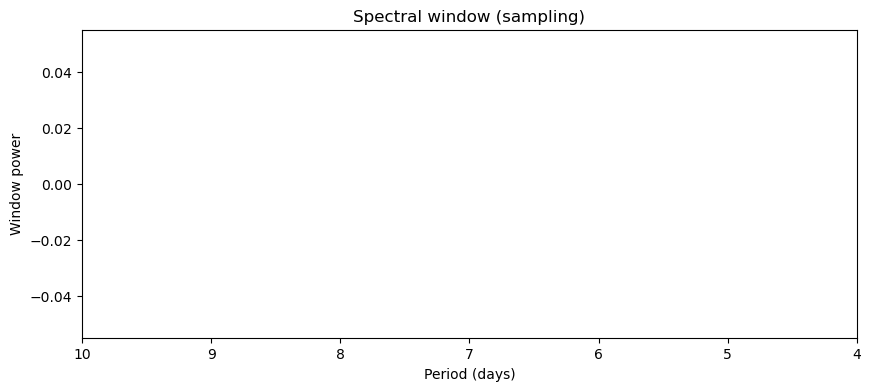

In [11]:
# Spectral window (sampling)
unit_signal = np.ones_like(time_rel)
ls_window = LombScargle(time_rel, unit_signal)
freq_w, power_w = ls_window.autopower(minimum_frequency=min_freq, maximum_frequency=max_freq, samples_per_peak=5)
period_w = 1.0 / freq_w
plt.figure(); plt.plot(period_w, power_w); plt.xlim(max_period, min_period)
plt.xlabel('Period (days)'); plt.ylabel('Window power'); plt.title('Spectral window (sampling)'); plt.show()


Best period chosen for folding: 4.21334490004372


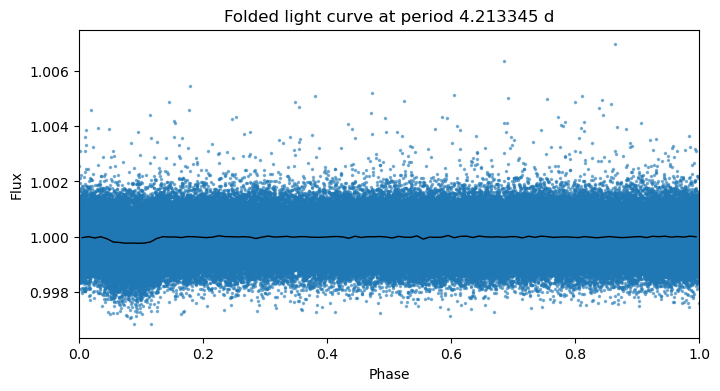

In [12]:
# Folding at the best refined period (if found), otherwise try LS or lightkurve result
best_period = None
if 'refined_results' in globals() and len(refined_results) > 0:
    best_period = refined_results[0]['best_period']
elif ('lk_pg' in globals()) and (lk_pg is not None):
    try:
        best_period = float(lk_pg.period_at_max_power)
    except:
        best_period = None
elif 'best_period_ls' in globals():
    best_period = best_period_ls

print('Best period chosen for folding:', best_period)
if best_period is not None:
    phase = ((time_rel % best_period) / best_period)
    phase = (phase + 0.5) % 1.0
    order = np.argsort(phase)
    p_sorted = phase[order]; f_sorted = flux[order]
    plt.figure(figsize=(8,4)); plt.plot(p_sorted, f_sorted, '.', markersize=3, alpha=0.5)
    from scipy import stats
    bins = 100
    bin_means, bin_edges, binnumber = stats.binned_statistic(p_sorted, f_sorted, statistic='median', bins=bins)
    bin_centers = 0.5*(bin_edges[:-1] + bin_edges[1:])
    plt.plot(bin_centers, bin_means, '-k', lw=1)
    plt.xlabel('Phase'); plt.ylabel('Flux'); plt.title(f'Folded light curve at period {best_period:.6f} d')
    plt.xlim(0,1); plt.show()
else:
    print('No best period determined yet. Run the periodogram cells first.')


In [13]:
# Save refined results to JSON
import json
out = {}
out['refined_results'] = refined_results if 'refined_results' in globals() else []
if 'best_period_ls' in globals():
    out['best_period_ls'] = float(best_period_ls)
with open('periodogram_refined_results.json', 'w') as f:
    json.dump(out, f, indent=2)
print('Saved periodogram_refined_results.json')

Saved periodogram_refined_results.json


---
## Notes
- The coarse search uses `n_coarse` periods across your full search range (fast).
- The refined search centers on up to the top 3 candidates and scans a small fractional window `refine_width` around each with high resolution `n_refined`.
- Adjust `n_coarse`, `n_refined`, and `refine_width` to trade speed vs precision.
- If `BoxLeastSquares.autopower` is not available or fails due to astropy version differences, consider upgrading astropy (`pip install -U astropy`).

---
Generated by ChatGPT (not executed here).